In [25]:
# Importing libraries
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.model_selection import train_test_split

# Define the path to the dataset. You can change this to your local file path if needed.
path = 'http://storage.googleapis.com/download.tensorflow.org/data/ecg.csv'

# Read the ECG dataset into a Pandas DataFrame
data = pd.read_csv(path, header=None)

In [26]:
data.head()

,0,1,2,3,4,5,6,7,8,9,...,131,132,133,134,135,136,137,138,139,140
0,-0.112522,-2.827204,-3.773897,-4.349751,-4.376041,-3.474986,-2.181408,-1.818286,-1.250522,-0.477492,...,0.792168,0.933541,0.796958,0.578621,0.257740,0.228077,0.123431,0.925286,0.193137,1.0
1,-1.100878,-3.996840,-4.285843,-4.506579,-4.022377,-3.234368,-1.566126,-0.992258,-0.754680,0.042321,...,0.538356,0.656881,0.787490,0.724046,0.555784,0.476333,0.773820,1.119621,-1.436250,1.0
2,-0.567088,-2.593450,-3.874230,-4.584095,-4.187449,-3.151462,-1.742940,-1.490659,-1.183580,-0.394229,...,0.886073,0.531452,0.311377,-0.021919,-0.713683,-0.532197,0.321097,0.904227,-0.421797,1.0
3,0.490473,-1.914407,-3.616364,-4.318823,-4.268016,-3.881110,-2.993280,-1.671131,-1.333884,-0.965629,...,0.350816,0.499111,0.600345,0.842069,0.952074,0.990133,1.086798,1.403011,-0.383564,1.0
4,0.800232,-0.874252,-2.384761,-3.973292,-4.338224,-3.802422,-2.534510,-1.783423,-1.594450,-0.753199,...,1.148884,0.958434,1.059025,1.371682,1.277392,0.960304,0.971020,1.614392,1.421456,1.0


In [27]:
# Get information about the dataset, such as column data types and non-null counts
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4998 entries, 0 to 4997
Columns: 141 entries, 0 to 140
dtypes: float64(141)
memory usage: 5.4 MB


In [28]:
# Splitting the dataset into features and target
features = data.drop(140, axis=1)  # Features are all columns except the last (column 140)
target = data[140]  # Target is the last column (column 140)

# Split the data into training and testing sets (80% training, 20% testing)
x_train, x_test, y_train, y_test = train_test_split(
    features, target, test_size=0.2
)

# Get the indices of the training data points labeled as "1" (anomalies)
train_index = y_train[y_train == 1].index

# Select the training data points that are anomalies
train_data = x_train.loc[train_index]

In [29]:
# Initialize the Min-Max Scaler to scale the data between 0 and 1
min_max_scaler = MinMaxScaler(feature_range=(0, 1))

# Scale the training data
x_train_scaled = min_max_scaler.fit_transform(train_data.copy())

# Scale the testing data using the same scaler
x_test_scaled = min_max_scaler.transform(x_test.copy())

In [30]:
# Creating an Autoencoder model by extending the Model class from Keras
class AutoEncoder(Model):
    def __init__(self, output_units, ldim=8):
        super().__init__()
        # Define the encoder part of the Autoencoder
        self.encoder = Sequential([
            Dense(64, activation='relu'),
            Dropout(0.1),
            Dense(32, activation='relu'),
            Dropout(0.1),
            Dense(16, activation='relu'),
            Dropout(0.1),
            Dense(ldim, activation='relu')
        ])
        # Define the decoder part of the Autoencoder
        self.decoder = Sequential([
            Dense(16, activation='relu'),
            Dropout(0.1),
            Dense(32, activation='relu'),
            Dropout(0.1),
            Dense(64, activation='relu'),
            Dropout(0.1),
            Dense(output_units, activation='sigmoid')
        ])

    def call(self, inputs):
        # Forward pass through the Autoencoder
        encoded = self.encoder(inputs)
        decoded = self.decoder(encoded)
        return decoded

In [31]:
# Create an instance of the AutoEncoder model with the appropriate output units
model = AutoEncoder(output_units=x_train_scaled.shape[1])

# Compile the model with Mean Squared Logarithmic Error (MSLE) loss and Mean Squared Error (MSE) metric
model.compile(loss='msle', metrics=['mse'], optimizer='adam')

# Train the model using the scaled training data
history = model.fit(
    x_train_scaled,  # Input data for training
    x_train_scaled,  # Target data for training (autoencoder reconstructs the input)
    epochs=20,        # Number of training epochs
    batch_size=512,   # Batch size
    validation_data=(x_test_scaled, x_test_scaled),  # Validation data
    shuffle=True     # Shuffle the data during training
)

Epoch 1/20
5/5 [==============================] - 6s 198ms/step - loss: 0.0110 - mse: 0.0248 - val_loss: 0.0139 - val_mse: 0.0326
Epoch 2/20
5/5 [==============================] - 0s 38ms/step - loss: 0.0107 - mse: 0.0241 - val_loss: 0.0137 - val_mse: 0.0320
Epoch 3/20
5/5 [==============================] - 0s 38ms/step - loss: 0.0102 - mse: 0.0228 - val_loss: 0.0133 - val_mse: 0.0311
Epoch 4/20
5/5 [==============================] - 0s 37ms/step - loss: 0.0093 - mse: 0.0208 - val_loss: 0.0129 - val_mse: 0.0302
Epoch 5/20
5/5 [==============================] - 0s 39ms/step - loss: 0.0083 - mse: 0.0186 - val_loss: 0.0127 - val_mse: 0.0297
Epoch 6/20
5/5 [==============================] - 0s 37ms/step - loss: 0.0074 - mse: 0.0166 - val_loss: 0.0123 - val_mse: 0.0288
Epoch 7/20
5/5 [==============================] - 0s 37ms/step - loss: 0.0067 - mse: 0.0150 - val_loss: 0.0120 - val_mse: 0.0281
Epoch 8/20
5/5 [==============================] - 0s 37ms/step - loss: 0.0062 - mse: 0.0138 - va

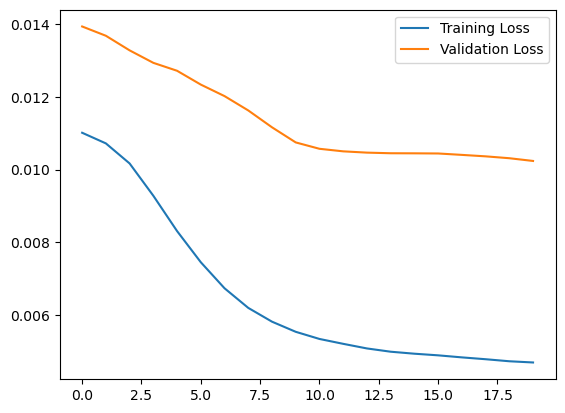

In [32]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()

In [33]:
# Function to find the threshold for anomalies based on the training data
def find_threshold(model, x_train_scaled):
    # Reconstruct the data using the model
    recons = model.predict(x_train_scaled)

    # Calculate the mean squared log error between reconstructed data and the original data
    recons_error = tf.keras.metrics.msle(recons, x_train_scaled)

    # Set the threshold as the mean error plus one standard deviation
    threshold = np.mean(recons_error.numpy()) + np.std(recons_error.numpy())

    return threshold

# Function to make predictions for anomalies based on the threshold
def get_predictions(model, x_test_scaled, threshold):
    # Reconstruct the data using the model
    predictions = model.predict(x_test_scaled)

    # Calculate the mean squared log error between reconstructed data and the original data
    errors = tf.keras.losses.msle(predictions, x_test_scaled)

    # Create a mask for anomalies based on the threshold
    anomaly_mask = pd.Series(errors) > threshold

    # Map True (anomalies) to 0 and False (normal data) to 1
    preds = anomaly_mask.map(lambda x: 0.0 if x == True else 1.0)

    return preds

# Find the threshold for anomalies
threshold = find_threshold(model, x_train_scaled)
print(f"Threshold: {threshold}")

74/74 [==============================] - 1s 4ms/step
Threshold: 0.010169156516037694


In [34]:
# Get predictions for anomalies based on the model and threshold
predictions = get_predictions(model, x_test_scaled, threshold)

# Calculate the accuracy score by comparing the predicted anomalies to the true labels
accuracy = accuracy_score(predictions, y_test)

# Print the accuracy score
print(f"Accuracy Score: {accuracy}")

32/32 [==============================] - 0s 4ms/step
Accuracy Score: 0.952
